In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:

from torchvision import models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class DefectDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.images_dir = os.path.join(root_dir, "images")
        self.labels_dir = os.path.join(root_dir, "labels")
        self.image_files = [f for f in os.listdir(self.images_dir) if f.endswith(('.jpg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        label_path = os.path.join(self.labels_dir, self.image_files[idx].rsplit('.', 1)[0] + '.txt')

        image = Image.open(img_path).convert("RGB")
        img_size = image.size[::-1]  # (height, width)

        with open(label_path, 'r') as f:
            yolo_annotations = f.readlines()

        mask = self.yolo_polygon_to_mask(yolo_annotations, img_size)
        mask = Image.fromarray(mask)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

    def yolo_polygon_to_mask(self, yolo_annotations, img_size):
        mask = np.zeros(img_size, dtype=np.uint8)
        h, w = img_size

        for annotation in yolo_annotations:
            parts = annotation.strip().split()
            coords = list(map(float, parts[1:]))

            polygon = []
            for i in range(0, len(coords), 2):
                x = int(coords[i] * w)
                y = int(coords[i + 1] * h)
                polygon.append([x, y])

            polygon = np.array(polygon, dtype=np.int32)
            cv2.fillPoly(mask, [polygon], 1)

        return mask

In [ ]:
# 2. Data Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# 3. Load Data
data_dir = "/content/drive/MyDrive/SpaceVela 3D-CV 1 class fail.v1i.yolov11.zip (Unzipped Files)"
train_dataset = DefectDataset(os.path.join(data_dir, "train"), transform=transform)
val_dataset = DefectDataset(os.path.join(data_dir, "valid"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Define convolution + ReLU block
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

# Define U-Net architecture
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Load pre-trained ResNet18 model
        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        # Encoder layers
        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        # Upsampling layers
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        # Initial convolution layers
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        # Final output layer
        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

# Initialize model, loss function, and optimizer
model = UNet(n_class=1).cuda()
pos_weight = torch.tensor([5.0]).cuda()
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Training loop
for epoch in range(30):
    model.train()
    for ii, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print('Epoch: {} - Loss: {:.6f}'.format(epoch + 1, loss.item()))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1 - Loss: 0.003577
Epoch: 2 - Loss: 0.010240
Epoch: 3 - Loss: 0.011244
Epoch: 4 - Loss: 0.006369
Epoch: 5 - Loss: 0.015584
Epoch: 6 - Loss: 0.013933
Epoch: 7 - Loss: 0.011899
Epoch: 8 - Loss: 0.014063
Epoch: 9 - Loss: 0.003471
Epoch: 10 - Loss: 0.003036
Epoch: 11 - Loss: 0.010890
Epoch: 12 - Loss: 0.004488
Epoch: 13 - Loss: 0.016702
Epoch: 14 - Loss: 0.004956
Epoch: 15 - Loss: 0.008246
Epoch: 16 - Loss: 0.003496
Epoch: 17 - Loss: 0.014226
Epoch: 18 - Loss: 0.004394
Epoch: 19 - Loss: 0.021938
Epoch: 20 - Loss: 0.037325
Epoch: 21 - Loss: 0.017429
Epoch: 22 - Loss: 0.024176
Epoch: 23 - Loss: 0.032312
Epoch: 24 - Loss: 0.002670
Epoch: 25 - Loss: 0.030875
Epoch: 26 - Loss: 0.028633
Epoch: 27 - Loss: 0.008587
Epoch: 28 - Loss: 0.000851
Epoch: 29 - Loss: 0.003513
Epoch: 30 - Loss: 0.002573


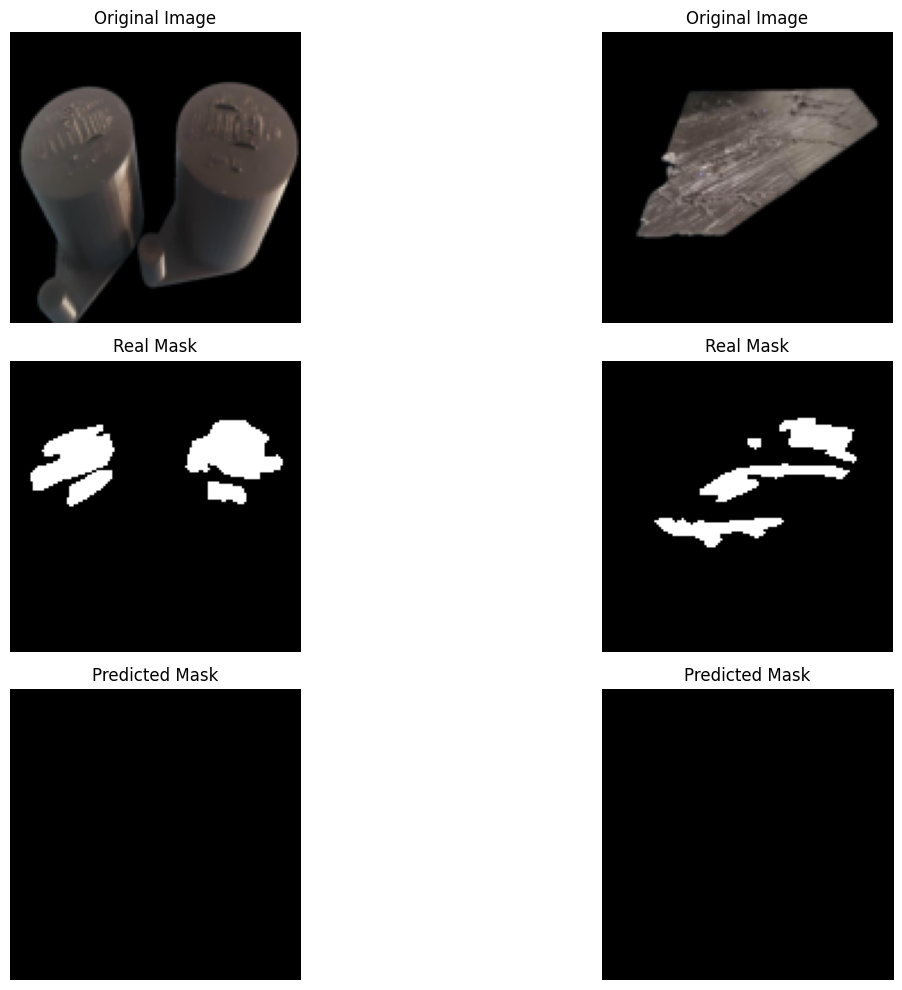

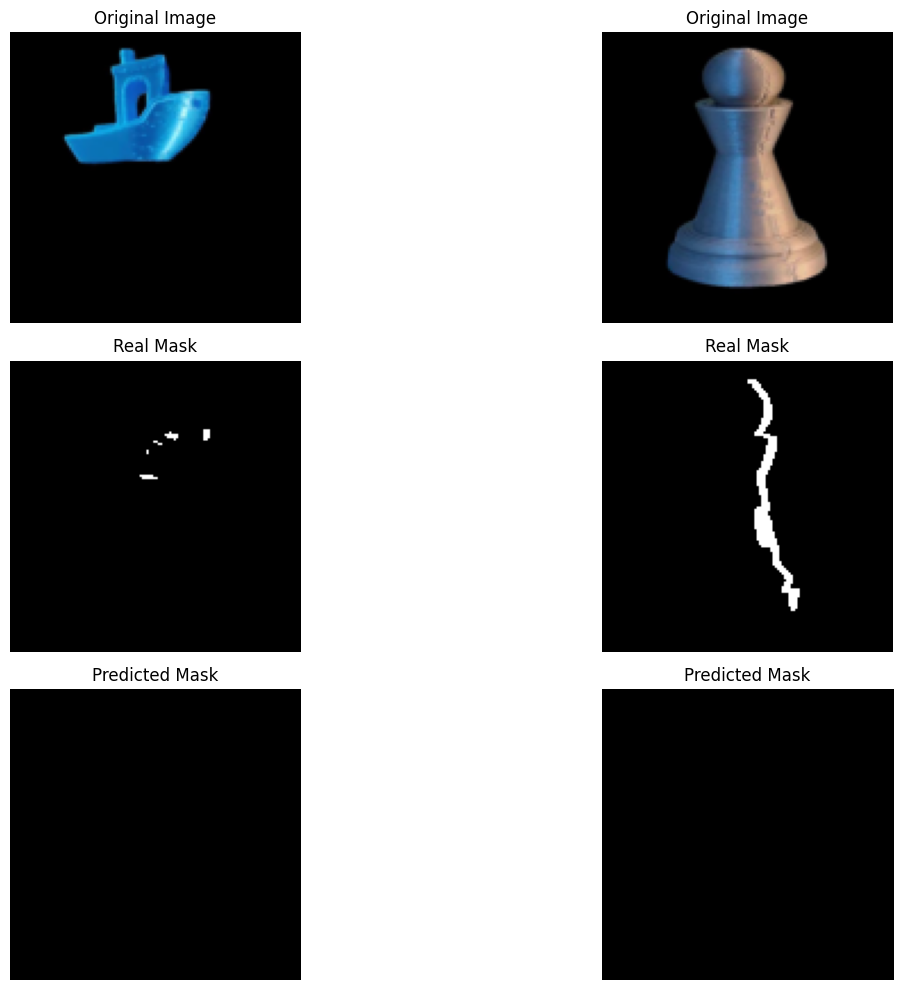

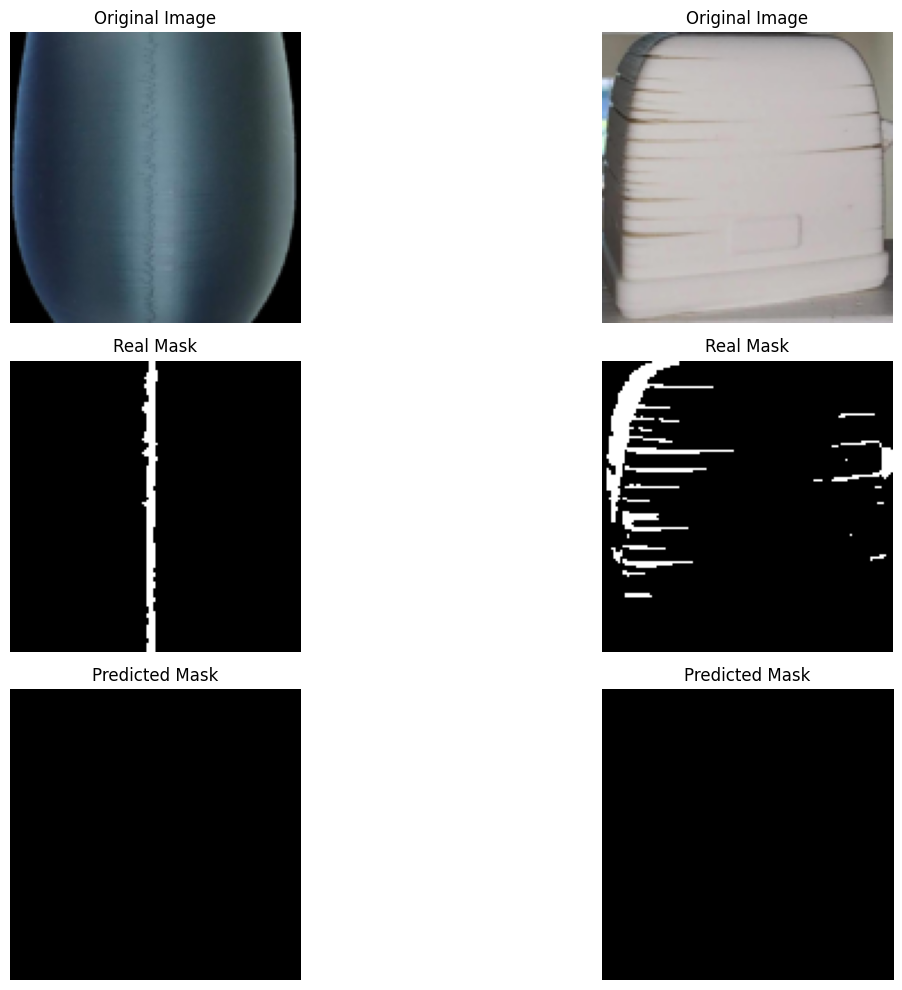

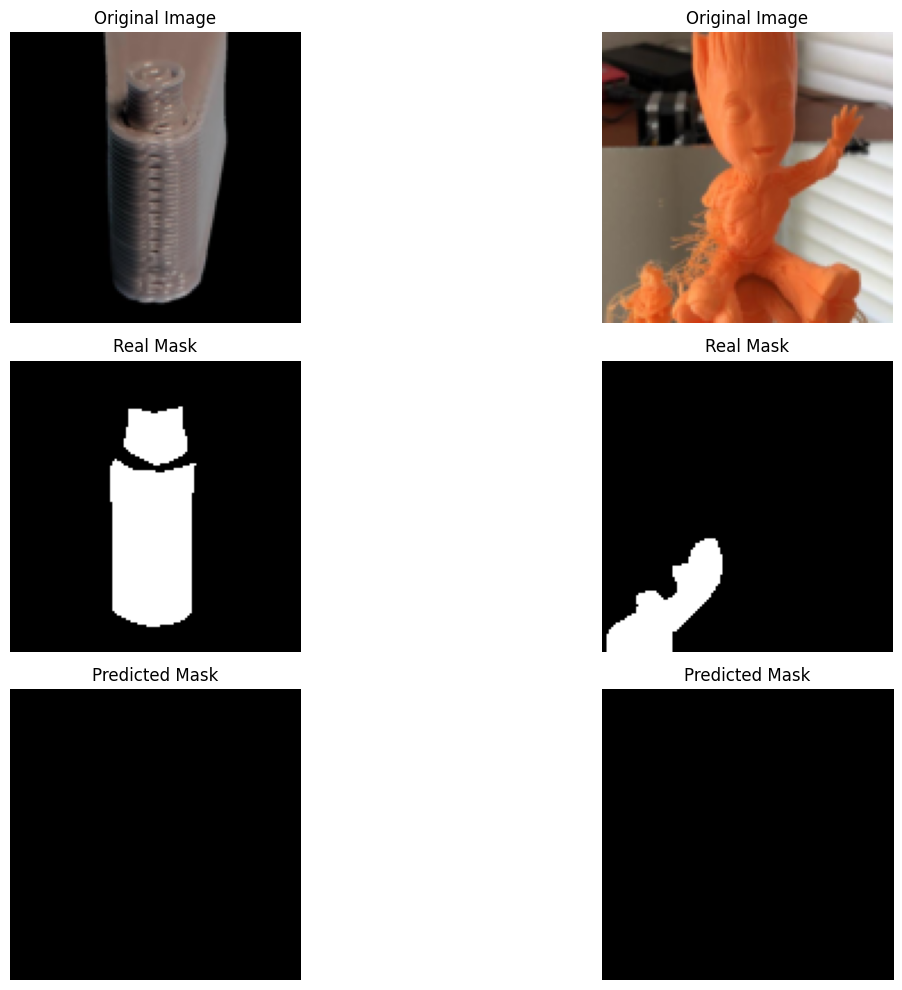

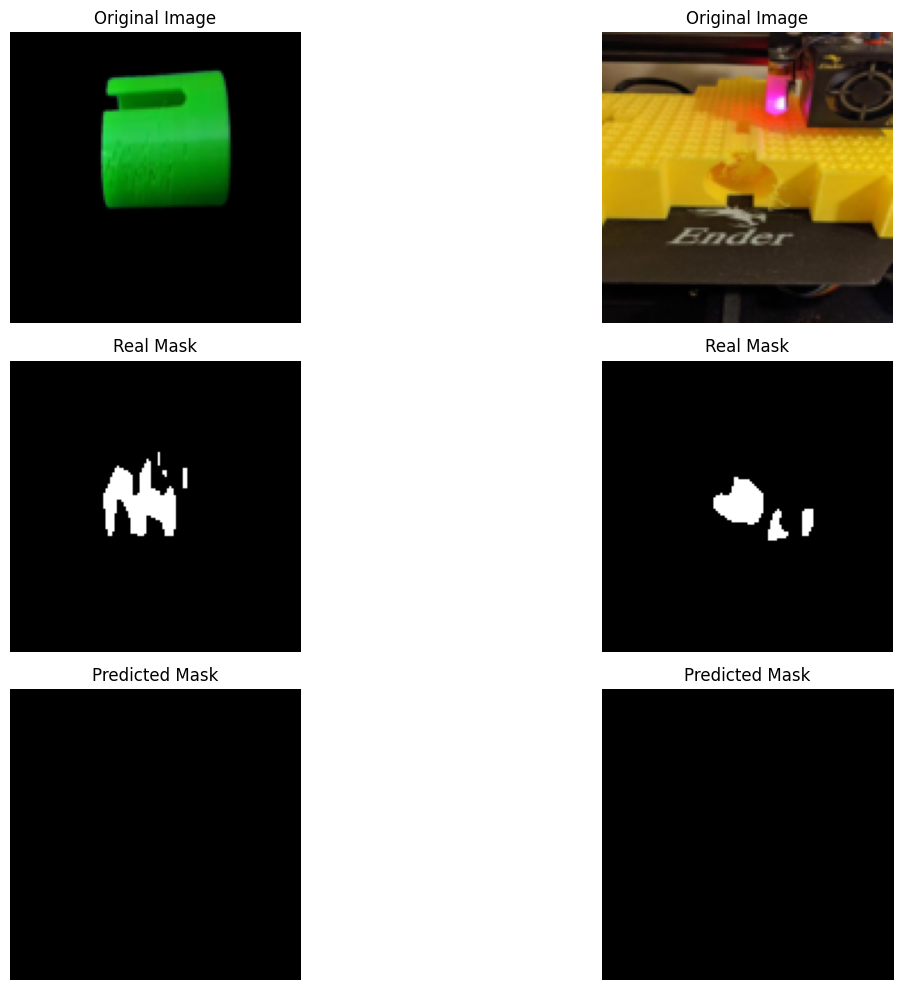

In [ ]:
# Visualization of real masks vs predicted masks
model.eval()
with torch.no_grad():
    for i, (data, target) in enumerate(train_loader):
        if i == 5:  # Display first 5 batches instead of 3
            break
        data, target = data.cuda(), target.cuda()

        output = model(data)
        pred_mask = torch.sigmoid(output) > 0.05  # Apply threshold to get binary mask

        fig, axs = plt.subplots(3, data.size(0), figsize=(15, 10))  # Increased figure size
        for idx in range(data.size(0)):
            axs[0, idx].imshow(data[idx].permute(1, 2, 0).cpu().numpy())
            axs[0, idx].set_title('Original Image')
            axs[0, idx].axis('off')


            axs[1, idx].imshow(target[idx].squeeze().cpu(), cmap='gray')
            axs[1, idx].set_title('Real Mask')
            axs[1, idx].axis('off')

            axs[2, idx].imshow(pred_mask[idx].squeeze().cpu(), cmap='gray')
            axs[2, idx].set_title('Predicted Mask')
            axs[2, idx].axis('off')

        plt.tight_layout()
        plt.show()


In [ ]:
print(torch.sigmoid(output).min().item(), torch.sigmoid(output).max().item())


1.0650673232248664e-07 0.033250726759433746
